Ressources :
- https://netcarbon.notion.site/Senior-Data-engineer-exercice-ee2f44d703804eb68a42bfb819b45dca
- https://www.agricolus.com/en/vegetation-indices-ndvi-ndmi/
- https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/
- https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [12]:
import numpy as np
%matplotlib inline

import pandas as pd
import geopandas as gpd
import contextily as cx
import rich.table
import math
from matplotlib import pyplot as plt
from pystac_client import Client
from shapely import wkt
from odc.stac import stac_load

In [2]:
tournesol_df = pd.read_csv('../sampled_rpg_data/tournesol.csv')
maize_df = pd.read_csv('../sampled_rpg_data/maize.csv')
rpg_df = pd.concat([tournesol_df, maize_df])
rpg_df['geometry'] = rpg_df['geometry'].apply(wkt.loads)

In [3]:
rpg_gdf = gpd.GeoDataFrame(rpg_df, crs='epsg:2154').to_crs(crs='epsg:4326')
rpg_gdf.head()

,Unnamed: 0,ID_PARCEL_2022,SURF_PARC_2022,CODE_CULTU_2022,CODE_GROUP_2022,CULTURE_D1_2022,CULTURE_D2_2022,geometry,libelle_cultu_2022,CAMPAGNE_DEBUT_2022,CAMPAGNE_FIN_2022,libelle_d1_2022,libelle_d2_2022,area
0,187842,1133906,9.71,TRN,6,NaN,NaN,"POLYGON ((0.97091 43.54035, 0.97132 43.54032, ...",Tournesol,2015,NaN,NaN,NaN,97114.949260
1,139550,841881,3.76,TRN,6,NaN,NaN,"POLYGON ((1.97183 43.86112, 1.97183 43.86112, ...",Tournesol,2015,NaN,NaN,NaN,37550.814191
2,1564874,9453515,3.38,TRN,6,NaN,NaN,"POLYGON ((1.09581 43.7644, 1.09581 43.7644, 1....",Tournesol,2015,NaN,NaN,NaN,33768.372757
3,1036094,6261084,0.94,TRN,6,NaN,NaN,"POLYGON ((0.34178 43.29936, 0.34089 43.29935, ...",Tournesol,2015,NaN,NaN,NaN,9369.597735
4,1169290,7064460,0.58,TRN,6,NaN,NaN,"POLYGON ((0.32516 43.83757, 0.32468 43.83785, ...",Tournesol,2015,NaN,NaN,NaN,5755.995216


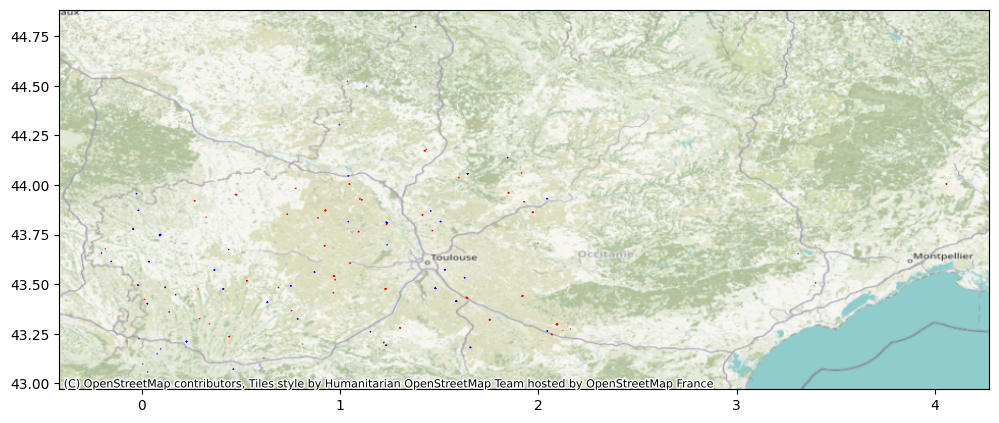

In [4]:
ax = rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "TRN"].plot(figsize=(12, 12), edgecolor='red')
rpg_gdf[rpg_gdf["CODE_CULTU_2022"] == "MIS"].plot(ax=ax, edgecolor='blue')
cx.add_basemap(ax, crs=rpg_gdf.crs)

0.734248950667171 43.8526350257301


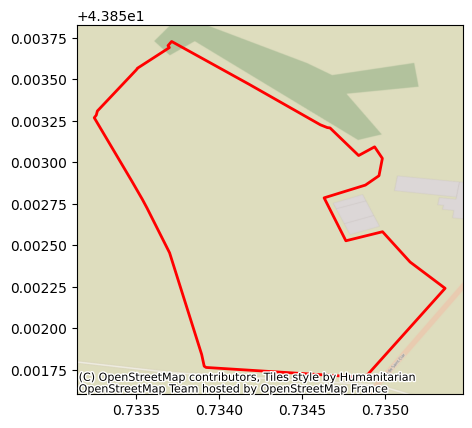

In [5]:
sample_poly = rpg_gdf.iloc[5]["geometry"]
sample_poly_gdf = gpd.GeoDataFrame({'geometry': [sample_poly]}, crs='epsg:4326')
print(sample_poly.centroid.x, sample_poly.centroid.y)

ax = sample_poly_gdf.plot(edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax, crs=rpg_gdf.crs)

In [6]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")

In [7]:
query = catalog.search(collections=["sentinel-2-l2a"], datetime="2023-01-01/2023-12-31", limit=100, intersects=sample_poly)

In [8]:
items = query.item_collection()
len(items)

138

In [9]:
sentinel_gdf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
sentinel_gdf.head()

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:datastrip_id,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated
0,"POLYGON ((-0.49642 44.22597, -0.53725 43.23828...",2023-12-31T17:41:23.733Z,sentinel-2a,sentinel-2,[msi],93.829376,32630,30,T,YP,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:58:59.043000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/30/T/Y...,roda-sentinel2/workflow-sentinel2-to-stac/ddba...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:41:23.733Z
1,"POLYGON ((0.49594 44.22596, 0.53678 43.23827, ...",2023-12-31T17:11:52.237Z,sentinel-2a,sentinel-2,[msi],98.205370,32631,31,T,CJ,...,S2A_OPER_MSI_L2A_DS_2APS_20231231T152149_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231231T152149_A0445...,1.034038,2023-12-31T10:58:55.714000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/0f14...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-31T17:11:52.237Z
2,"POLYGON ((-0.49642 44.22597, -0.53725 43.23828...",2023-12-26T15:41:29.749Z,sentinel-2b,sentinel-2,[msi],71.980369,32630,30,T,YP,...,S2B_OPER_MSI_L2A_DS_2BPS_20231226T123045_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20231226T123045_A0355...,1.033528,2023-12-26T10:59:03.449000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/30/T/Y...,roda-sentinel2/workflow-sentinel2-to-stac/02d7...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-26T15:41:29.749Z
3,"POLYGON ((0.49594 44.22596, 0.53678 43.23827, ...",2023-12-26T14:44:36.961Z,sentinel-2b,sentinel-2,[msi],91.595584,32631,31,T,CJ,...,S2B_OPER_MSI_L2A_DS_2BPS_20231226T123045_S2023...,S2B_OPER_MSI_L2A_TL_2BPS_20231226T123045_A0355...,1.033528,2023-12-26T10:59:00.120000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/31/T/C...,roda-sentinel2/workflow-sentinel2-to-stac/1ea9...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-26T14:44:36.961Z
4,"POLYGON ((-0.49642 44.22597, -0.53725 43.23828...",2023-12-21T19:25:25.326Z,sentinel-2a,sentinel-2,[msi],99.956012,32630,30,T,YP,...,S2A_OPER_MSI_L2A_DS_2APS_20231221T165248_S2023...,S2A_OPER_MSI_L2A_TL_2APS_20231221T165248_A0443...,1.032764,2023-12-21T10:58:58.074000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/30/T/Y...,roda-sentinel2/workflow-sentinel2-to-stac/869b...,True,{'sentinel2-to-stac': '0.1.1'},2023-12-21T19:25:25.326Z


<Axes: >

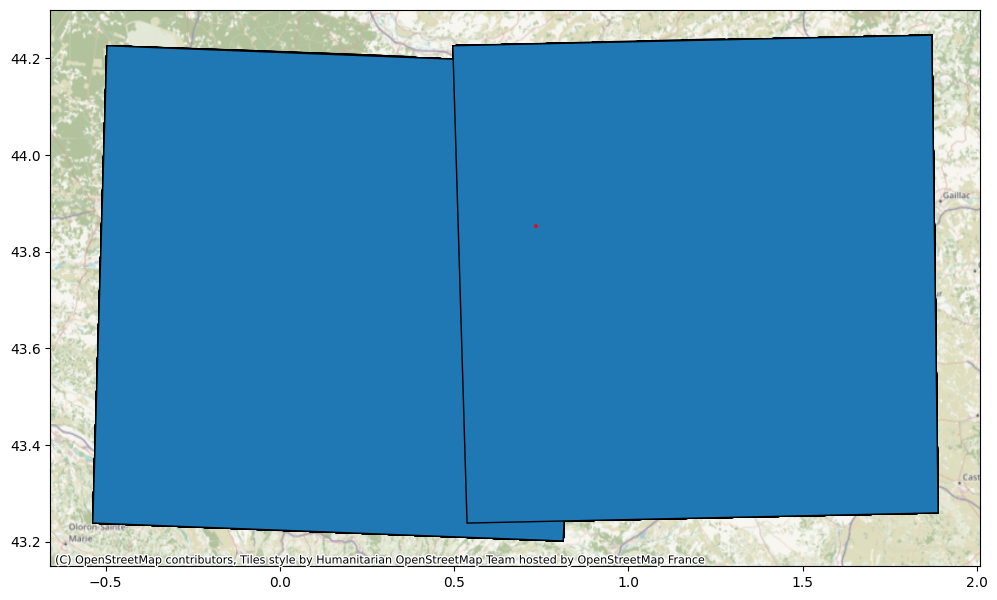

In [10]:
ax = sentinel_gdf.plot(edgecolor="k", figsize=(12, 12))
cx.add_basemap(ax=ax, crs=sentinel_gdf.crs)
sample_poly_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

In [13]:
sample_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in sample_item.assets.items():
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key         ┃ Description                     ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ aot               │ Aerosol optical thickness (AOT) │
│ blue              │ Blue (band 2) - 10m             │
│ coastal           │ Coastal aerosol (band 1) - 60m  │
│ granule_metadata  │                                 │
│ green             │ Green (band 3) - 10m            │
│ nir               │ NIR 1 (band 8) - 10m            │
│ nir08             │ NIR 2 (band 8A) - 20m           │
│ nir09             │ NIR 3 (band 9) - 60m            │
│ red               │ Red (band 4) - 10m              │
│ rededge1          │ Red edge 1 (band 5) - 20m       │
│ rededge2          │ Red edge 2 (band 6) - 20m       │
│ rededge3          │ Red edge 3 (band 7) - 20m       │
│ scl               │ Scene classification map (SCL)  │
│ swir16            │ SWIR 1 (band 11) - 20m          │
│ swir22            │ SWIR 2 (band 12) - 20m          │
│ thumbnail         │ Thumbnail image                 │
│ tileinfo_metadata │                                 │
│ visual            │ True color image                │
│ wvp               │ Water vapour (WVP)              │
│ aot-jp2           │ Aerosol optical thickness (AOT) │
│ blue-jp2          │ Blue (band 2) - 10m             │
│ coastal-jp2       │ Coastal aerosol (band 1) - 60m  │
│ green-jp2         │ Green (band 3) - 10m            │
│ nir-jp2           │ NIR 1 (band 8) - 10m            │
│ nir08-jp2         │ NIR 2 (band 8A) - 20m           │
│ nir09-jp2         │ NIR 3 (band 9) - 60m            │
│ red-jp2           │ Red (band 4) - 10m              │
│ rededge1-jp2      │ Red edge 1 (band 5) - 20m       │
│ rededge2-jp2      │ Red edge 2 (band 6) - 20m       │
│ rededge3-jp2      │ Red edge 3 (band 7) - 20m       │
│ scl-jp2           │ Scene classification map (SCL)  │
│ swir16-jp2        │ SWIR 1 (band 11) - 20m          │
│ swir22-jp2        │ SWIR 2 (band 12) - 20m          │
│ visual-jp2        │ True color image                │
│ wvp-jp2           │ Water vapour (WVP)              │
└───────────────────┴─────────────────────────────────┘

In [14]:
minx, miny, maxx, maxy = sample_poly.bounds
print(minx, miny, maxx, maxy) 

0.7332470777338325 43.851702969848844 0.7353610859681843 43.853727665545854


In [15]:
resolution = 0.001

In [16]:
minx, miny, maxx, maxy = (math.floor(minx / resolution) * resolution,
                         math.floor(miny / resolution) * resolution,
                         math.ceil(maxx / resolution) * resolution,
                         math.ceil(maxy / resolution) * resolution)
print(minx, miny, maxx, maxy) 

0.733 43.851 0.736 43.854


In [65]:
xx = stac_load(items, 
               bands=["scl", "nir", "red", "swir16"], 
               crs="epsg:4326", 
               resolution=resolution / 100, 
               chunks={}, 
               groupby="solar_day",
               bbox=(minx, miny, maxx, maxy))


In [67]:
xx["nir"] = xx.nir.astype(int)
xx["red"] = xx.red.astype(int)
xx["swir16"] = xx.swir16.astype(int)

xx["ndvi"] = (xx.nir - xx.red) / (xx.nir + xx.red)
xx["ndmi"] = (xx.nir - xx.swir16) / (xx.nir + xx.swir16)
xx

<xarray.Dataset> Size: 258MB
Dimensions:      (latitude: 300, longitude: 300, time: 70)
Coordinates:
  * latitude     (latitude) float64 2kB 43.85 43.85 43.85 ... 43.85 43.85 43.85
  * longitude    (longitude) float64 2kB 0.733 0.733 0.733 ... 0.736 0.736 0.736
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 560B 2023-01-05T10:58:57.696000 ... 20...
Data variables:
    scl          (time, latitude, longitude) uint8 6MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    nir          (time, latitude, longitude) int64 50MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    red          (time, latitude, longitude) int64 50MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    swir16       (time, latitude, longitude) int64 50MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ndvi         (time, latitude, longitude) float64 50MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>
    ndmi         (time, latitude, longitude) float64 50MB dask.array<chunksize=(1, 300, 300), meta=np.ndarray>

In [68]:
%%time
xx = xx.compute()

CPU times: total: 3.88 s
Wall time: 23.3 s


In [69]:
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
xx = xx.where(xx.scl.isin([4,5,6,7]), drop=True)
xx

<xarray.Dataset> Size: 115MB
Dimensions:      (time: 29, latitude: 300, longitude: 300)
Coordinates:
  * latitude     (latitude) float64 2kB 43.85 43.85 43.85 ... 43.85 43.85 43.85
  * longitude    (longitude) float64 2kB 0.733 0.733 0.733 ... 0.736 0.736 0.736
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 232B 2023-02-04T10:58:57.575000 ... 20...
Data variables:
    scl          (time, latitude, longitude) float32 10MB 5.0 5.0 ... 5.0 5.0
    nir          (time, latitude, longitude) float64 21MB 1.642e+03 ... 1.448...
    red          (time, latitude, longitude) float64 21MB 1.102e+03 ... 976.0
    swir16       (time, latitude, longitude) float64 21MB 2.33e+03 ... 1.395e+03
    ndvi         (time, latitude, longitude) float64 21MB 0.1968 ... 0.1947
    ndmi         (time, latitude, longitude) float64 21MB -0.1732 ... 0.01864

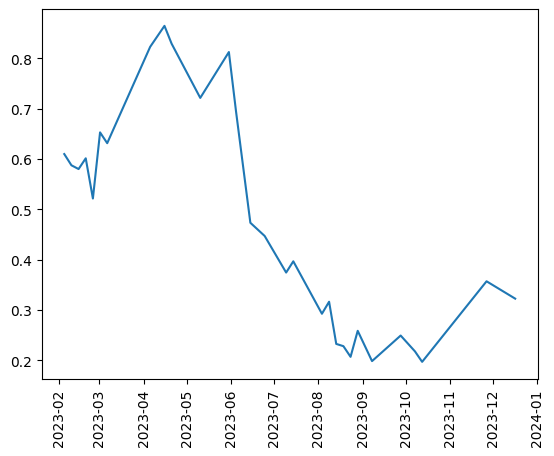

In [70]:
time_values = xx['time'].values
median_ndvis = []
for t in time_values:
    ndvi_t = xx.sel(time=t)['ndvi']
    median_ndvi_t = ndvi_t.median(dim=['latitude', 'longitude'], skipna=True)
    median_ndvis.append(median_ndvi_t)
    
plt.plot(time_values, median_ndvis)
ax = plt.xticks(rotation=90)

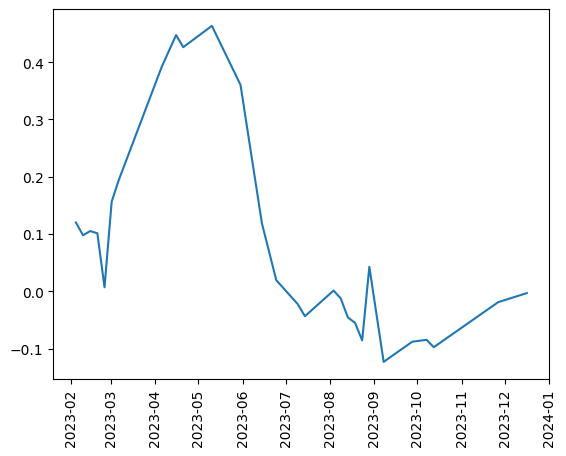

In [71]:
time_values = xx['time'].values
median_ndmis = []
for t in time_values:
    ndmi_t = xx.sel(time=t)['ndmi']
    median_ndmi_t = ndmi_t.median(dim=['latitude', 'longitude'], skipna=True)
    median_ndmis.append(median_ndmi_t)
    
plt.plot(time_values, median_ndmis)
ax = plt.xticks(rotation=90)